  # Test of hierarchical classification (model 2)
  
  This model uses four layers. In the first layer, every source is classified hierarchically as Stochastic, Transient or Periodic. Then, every source pass trough the next layers (Stochastic, Transient and Periodic). The final classification is dertermined by multiplying the probabilities of the first layer, with their correspondant probabilites of the Stochastic, Transient and Periodic layers. For instance, the probability of being RRL corresponds to the product of the probability of being periodic (according to the first layer) and the probability of being RRL (according to the periodic layer): 
 
 $$Prob_{final}(RRL) = Prob_{first \: layer}(Periodic)* Prob_{periodic \: layer}(RRL)$$
 
 And the probability of being a Blazar is computed as:
 
  $$Prob_{final}(Blazar) = Prob_{first \: layer}(Stochastic)* Prob_{stochastic \: layer}(Blazar)$$


 
 The final classification is definded by the maximum $Prob_{final}$
 


In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier



  ### Definition of names for plots and files

In [2]:
morethan5 = False

date = '20190925'

#names of files with detections, features and labels for the training set (v3)
labels_file = '../alerce_trainingset/training_set_v4/dfcrossmatches_prioritized_v4.csv'
detections_file = '../alerce_trainingset/training_set_v3/detections.pkl'
#features_file = '../alerce_trainingset/training_set_v3/features.pkl'
features_file = '../ZTF_data/features_20191017_filtered.pkl'
non_detections_file = '../alerce_trainingset/training_set_v3/training_non_det_v3.h5'

early_probs = '../ZTF_data/stamps_new.pkl'


class_output = '../ZTF_classifications/classification_unlabelled_set_with_early_20190926.csv'

#where the RF models are saved
if morethan5:
    model_first_layer = 'stat_prob_hierRF_model_2/rf_model_2_hierarchical_layer_morethan5gr_'+date
    model_periodic_layer = 'stat_prob_hierRF_model_2/rf_model_2_periodic_layer_morethan5gr_'+date
    model_transient_layer = 'stat_prob_hierRF_model_2/rf_model_2_transient_layer_morethan5gr_'+date
    model_stochastic_layer = 'stat_prob_hierRF_model_2/rf_model_2_stochastic_layer_morethan5gr_'+date

else: 
    model_first_layer = 'stat_prob_hierRF_model_2/rf_model_2_hierarchical_layer_'+date
    model_periodic_layer = 'stat_prob_hierRF_model_2/rf_model_2_periodic_layer_'+date
    model_transient_layer = 'stat_prob_hierRF_model_2/rf_model_2_transient_layer_'+date
    model_stochastic_layer = 'stat_prob_hierRF_model_2/rf_model_2_stochastic_layer_'+date

#confusion matrixes
if morethan5:
    conf_matrix_name_first_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_hierarchical_layer_morethan5gr_'+date
    conf_matrix_name_second_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_multiclass_morethan5gr_'+date

else:
    conf_matrix_name_first_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_hierarchical_layer_'+date
    conf_matrix_name_second_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_multiclass_'+date


#feature importances
if morethan5:
    feature_importance_name_first_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_hierarchical_layer_morethan5gr_'+date
    feature_importance_name_periodic_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_periodic_layer_morethan5gr_'+date
    feature_importance_name_transient_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_transient_layer_morethan5gr_'+date
    feature_importance_name_stochastic_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_stochastic_layer_morethan5gr_'+date
    
else: 
    feature_importance_name_first_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_hierarchical_layer_'+date
    feature_importance_name_periodic_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_periodic_layer_'+date
    feature_importance_name_transient_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_transient_layer_'+date
    feature_importance_name_stochastic_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_stochastic_layer_'+date

### reading the training set files 

In [3]:
df_nd = pd.read_hdf(non_detections_file)
df_feat = pd.read_pickle(features_file)
df_labels = pd.read_csv(labels_file,index_col='oid')
df_detections = pd.read_pickle(detections_file)

df_early_probs = pd.read_pickle(early_probs)
df_early_probs = df_early_probs.replace([np.inf, -np.inf], np.nan)
df_early_probs.fillna(-999,inplace=True)
#df_early_probs.drop(['bogus','asteroid'], axis=1, inplace=True)

print(df_early_probs.columns.values)
#deleting columns in df_nd with name ending in "_3"
#for col in list(df_nd):
#    if col[-2:] == "_3":
#        df_nd.drop(col, inplace=True, axis=1)

#getting gscore from the detections file
#df_det = df_detections.groupby(['oid'])
#df_sgscore = df_det['sgscore1'].median()
#df_sgscore = df_sgscore.to_frame()

#creating color features
#df_nd["g_r_max"] = df_nd.min_mag_fid_1 - df_nd.min_mag_fid_2
#df_feat["g_r_mean"] = df_feat.Mean_1 - df_feat.Mean_2

#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

df_early_probs.head()

/Users/psanchez/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['AGN' 'SN' 'VS' 'asteroid' 'bogus']


,AGN,SN,VS,asteroid,bogus
ZTF18abbktxw,0.112748,0.091780,0.562350,0.080806,0.152317
ZTF18abndukk,0.123997,0.110156,0.541206,0.101226,0.123415
ZTF18aaxyuzy,0.134978,0.101292,0.538376,0.078226,0.147128
ZTF18abjaayi,0.120710,0.129486,0.523450,0.076389,0.149964
ZTF18abptzkt,0.503977,0.118422,0.215396,0.071942,0.090264


In [4]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
df_labels.loc[(df_labels['class_source'] == 'RS CVn'), 'class_original'] = 'RS-CVn'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'

#defining the classes included in the RF model
label_order = ['AGN-I', 'Blazar', 'CV/Nova', 'SNIa', 'SNIbc', 'SNII',
               'SLSN', 'EBSD/D', 'EBC', 'DSCT', 'RRL', 'Ceph', 'RS-CVn', 'LPV','Periodic-Other']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

#defining hierarchical classes:

labels['class_hierachical'] = labels['class_original']

labels.loc[(labels['class_hierachical'] == 'EBSD/D') | (labels['class_hierachical'] == 'EBC')   | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'Ceph')  | (labels['class_hierachical'] == 'Periodic-Other'), 'class_hierachical'] = 'Periodic'

labels.loc[(labels['class_hierachical'] == 'SNIa') | (labels['class_hierachical'] == 'SNIbc') | (labels['class_hierachical'] == 'SNII') | (labels['class_hierachical'] == 'SLSN'), 'class_hierachical'] = 'Transient'

labels.loc[(labels['class_hierachical'] == 'RS-CVn') |  (labels['class_hierachical'] == 'CV/Nova')|  (labels['class_hierachical'] == 'LPV') | (labels['class_hierachical'] == 'AGN-I') | (labels['class_hierachical'] == 'Blazar')   , 'class_hierachical'] = 'Stochastic'


cm_classes_hierachical = ['Stochastic','Transient','Periodic']
#cm_classes_hierachical = ['Stochastic','Periodic']

cm_classes_original = label_order

labels.head()

,class_original,class_hierachical
oid,,
ZTF18aawaqeo,CV/Nova,Stochastic
ZTF18acaxfpa,CV/Nova,Stochastic
ZTF18abxehba,CV/Nova,Stochastic
ZTF18aaxjjwu,CV/Nova,Stochastic
ZTF18abnowur,CV/Nova,Stochastic


In [5]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_fid_1',
'n_det_fid_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',]
'''
'max_mjd_fid_1',
'max_mjd_fid_2',
'min_mjd_fid_1',
'min_mjd_fid_2',
'max_mag_fid_1',
'max_mag_fid_2',
'min_mag_fid_1',
'min_mag_fid_2',
'first_mag_fid_1',
'first_mag_fid_2',
'first_mjd_fid_1',
'first_mjd_fid_2']
'''

#combining all the DF
#df = labels.join(df_sgscore).join(df_feat).join(df_nd.drop(rm_nd_cols, axis=1))
#df = labels.join(df_sgscore).join(df_feat.drop(rm_nd_cols, axis=1))
#df = labels.join(df_feat.drop(rm_nd_cols, axis=1))
df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner').join(df_early_probs,how='left')
#df = labels.join(df_early_probs,how='left').join(df_feat.drop(rm_nd_cols, axis=1))
df_train = df
df_train.fillna(-999,inplace=True)
df.drop(['Mean_1', 'Mean_2','class_original','class_hierachical'], axis=1, inplace=True)
df.fillna(-999,inplace=True)
labels = labels.loc[df.index.values]

if morethan5:
    df = df[(df.n_samples_1 > 5) & (df.n_samples_2 > 5)]
    labels = labels.loc[df.index.values]

df.head()

,n_samples_1,Amplitude_1,AndersonDarling_1,Autocor_length_1,Beyond1Std_1,Con_1,Eta_e_1,Gskew_1,MaxSlope_1,Meanvariance_1,...,n_non_det_before_fid_2,positive_fraction_1,positive_fraction_2,rb,sgscore1,AGN,SN,VS,asteroid,bogus
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18aawaqeo,169.0,1.355516,1.000000,29.0,0.443787,0.0,0.116776,0.198519,0.965720,0.052072,...,0,0.005917,0.000000,0.745714,0.933429,0.134747,0.097592,0.506413,0.102136,0.159112
ZTF18acaxfpa,31.0,1.050090,0.863889,1.0,0.354839,0.0,1.111663,-0.441498,1.032640,0.028860,...,0,0.000000,0.344828,0.781429,0.996875,0.153566,0.116084,0.501802,0.098524,0.130024
ZTF18abxehba,19.0,0.567264,0.755074,2.0,0.210526,0.0,0.729148,-0.115097,0.110217,0.023405,...,0,0.421053,0.500000,0.820714,0.958750,0.102350,0.113347,0.537239,0.105469,0.141595
ZTF18aaxjjwu,43.0,0.283797,1.000000,1.0,0.186047,0.0,2.299237,0.307494,0.377524,0.009650,...,0,0.860465,0.400000,0.728571,1.000000,0.239197,0.111541,0.372207,0.085587,0.191467
ZTF18abnowur,10.0,3.249119,0.998628,3.0,0.500000,0.0,0.185406,-4.001855,0.574913,0.154373,...,0,0.900000,0.666667,0.833333,0.992708,0.567502,0.120024,0.166888,0.060537,0.085050


  ### Defining functions to plot the confusion matrix and the feature importance

In [6]:
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    if morethan5: title='Confusion matrix for more than 5 samples per band'

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    
    
def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(model.feature_importances_))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name)
    #plt.close()

### Pre-processing training data

In [7]:
Y_hierarchical = labels['class_hierachical']#.values
Y_original = labels['class_original']#.values

early_cols = ['VS','AGN','SN','asteroid','bogus']
vs_cols = ['bogus']

X_hierarchical = df#.columns.values.tolist()

#splitting training set
X_train_hierarchical, X_test_hierarchical, y_train_hierarchical, y_test_hierarchical, y_train_original, y_test_original  = model_selection.train_test_split(X_hierarchical,
Y_hierarchical, Y_original, test_size=0.2, stratify=Y_original)

# separating training sets for sub-classes
X_train_periodic = X_train_hierarchical.loc[y_train_hierarchical=='Periodic', :]
X_train_periodic = X_train_periodic.drop(early_cols,axis=1)
y_train_periodic = y_train_original.loc[y_train_hierarchical=='Periodic']

X_train_stochastic = X_train_hierarchical.loc[y_train_hierarchical=='Stochastic', :]
X_train_stochastic = X_train_stochastic.drop(vs_cols,axis=1)
y_train_stochastic = y_train_original.loc[y_train_hierarchical=='Stochastic']

X_train_transient = X_train_hierarchical.loc[y_train_hierarchical=='Transient', :]
X_train_transient = X_train_transient.drop(vs_cols,axis=1)
y_train_transient = y_train_original.loc[y_train_hierarchical=='Transient']

X_train_hierarchical = X_train_hierarchical.drop(early_cols,axis=1)

X_test_periodic = X_test_hierarchical.drop(early_cols,axis=1)
X_test_stochastic = X_test_hierarchical.drop(vs_cols,axis=1)
X_test_transient = X_test_hierarchical.drop(vs_cols,axis=1)
X_test_hierarchical = X_test_hierarchical.drop(early_cols,axis=1)


print(len(y_train_periodic), len(y_train_stochastic), len(y_train_transient))

48363 36242 732


  ## Balanced random forest
  
  ### First layer: separating Periodic, Stochastic and Transients:

In [8]:
#Training first layer of the RF model

rf_model_hierarchical = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=1,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_hierarchical.fit(X_train_hierarchical, y_train_hierarchical)

#testing first layer performance

y_true, y_pred = y_test_hierarchical, rf_model_hierarchical.predict(X_test_hierarchical)
y_pred_proba_hier = rf_model_hierarchical.predict_proba(X_test_hierarchical)

classes_order_proba_hierarchical = rf_model_hierarchical.classes_
print(classes_order_proba_hierarchical)

#c = np.c_[y_pred_proba_hier, y_test_original]
#c = np.c_[c, y_pred_]
#print(c)

print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true, y_pred))

#Dumping trained model

features_hierarchical = list(X_train_hierarchical)

with open(model_first_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_hierarchical,
            'features': features_hierarchical,
            'order_classes': classes_order_proba_hierarchical
            }
        pickle.dump(model_dump, pickle_file)

['Periodic' 'Stochastic' 'Transient']
Accuracy: 0.9601593625498008
Balanced accuracy: 0.9642685524123417


[[ 8699    84   277]
 [    5   178     0]
 [  483     1 11608]]
Normalized confusion matrix


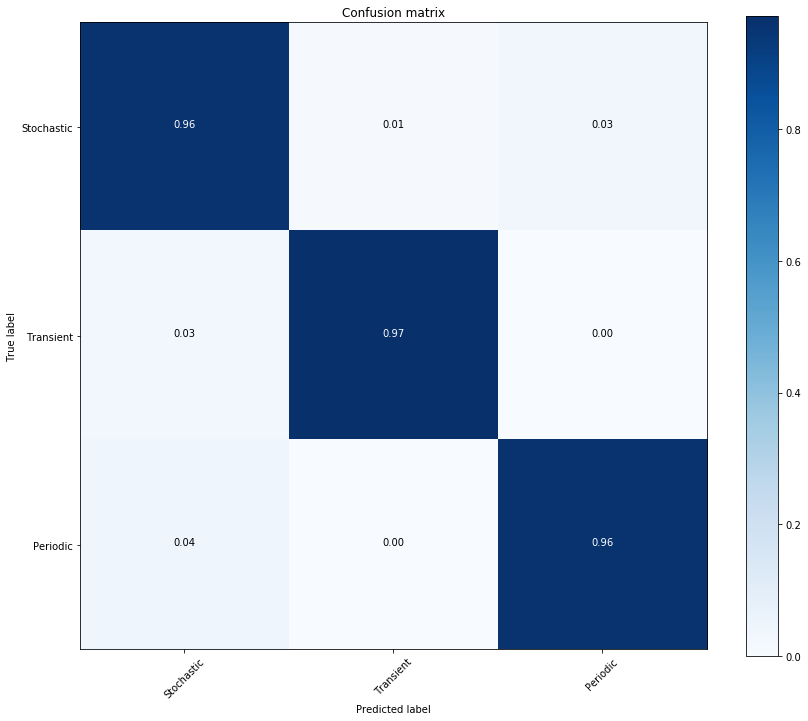

In [9]:
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=cm_classes_hierachical)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,cm_classes_hierachical,conf_matrix_name_first_layer)

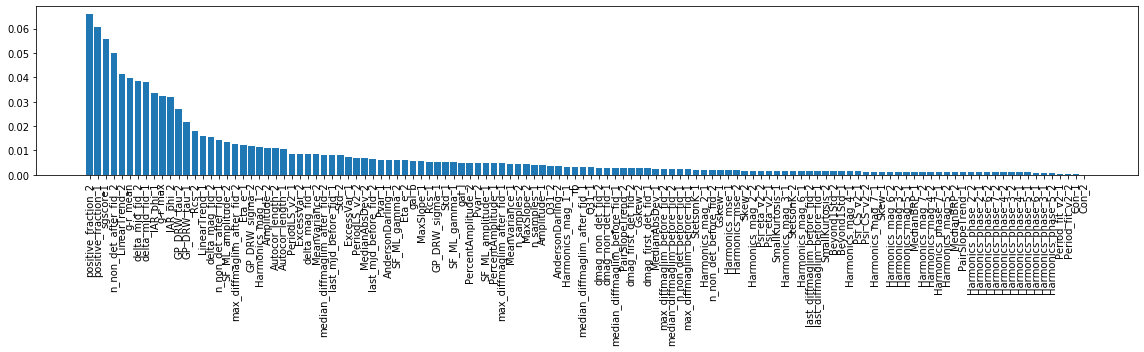

In [10]:
#plotting feature importance
plot_feature_importances(rf_model_hierarchical, features_hierarchical, feature_importance_name_first_layer)

  ### Periodic layer

In [11]:
#Training Periodic layer

rf_model_periodic = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=1,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_periodic.fit(X_train_periodic, y_train_periodic)

# Applying periodic model to the test data

y_true_periodic, y_pred_periodic = y_test_original, rf_model_periodic.predict(X_test_periodic)
y_pred_proba_periodic = rf_model_periodic.predict_proba(X_test_periodic)

classes_order_proba_periodic = rf_model_periodic.classes_
print(classes_order_proba_periodic)

#Dumping trained model

features_periodic = list(X_train_periodic)

with open(model_periodic_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_periodic,
            'features': features_periodic,
            'order_classes': classes_order_proba_periodic
            }
        pickle.dump(model_dump, pickle_file)

['Ceph' 'DSCT' 'EBC' 'EBSD/D' 'Periodic-Other' 'RRL']


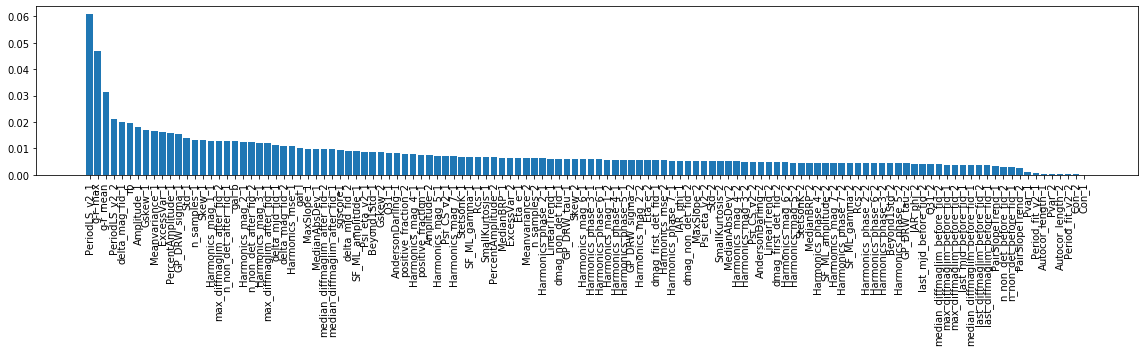

In [12]:
#plotting feature importance
plot_feature_importances(rf_model_periodic, features_hierarchical, feature_importance_name_first_layer)

  ### Stochastic layer

In [13]:
#Training Stochastic layer

rf_model_stochastic = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=1,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)


rf_model_stochastic.fit(X_train_stochastic, y_train_stochastic)

# Applying stochastic model to the test data

y_true_stochastic, y_pred_stochastic  = y_test_original, rf_model_stochastic.predict(X_test_stochastic)
y_pred_proba_stochastic = rf_model_stochastic.predict_proba(X_test_stochastic)

classes_order_proba_stochastic = rf_model_stochastic.classes_
print(classes_order_proba_stochastic)

#Dumping trained model

features_stochastic = list(X_train_stochastic)

with open(model_stochastic_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_stochastic,
            'features': features_stochastic,
            'order_classes': classes_order_proba_stochastic
            }
        pickle.dump(model_dump, pickle_file)

['AGN-I' 'Blazar' 'CV/Nova' 'LPV' 'RS-CVn']


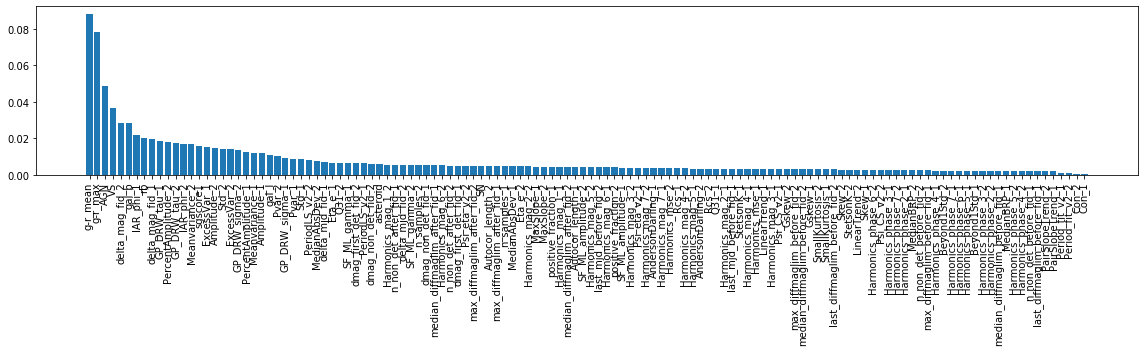

In [14]:
#plotting feature importance
plot_feature_importances(rf_model_stochastic, features_stochastic, feature_importance_name_stochastic_layer)

  ### Transient layer

In [15]:
#Training Transient layer

rf_model_transient = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=1,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)


rf_model_transient.fit(X_train_transient, y_train_transient)

# Applying transient model to the test data

y_true_transient, y_pred_transient  = y_test_original, rf_model_transient.predict(X_test_transient)
y_pred_proba_transient = rf_model_transient.predict_proba(X_test_transient)

classes_order_proba_transient = rf_model_transient.classes_
print(classes_order_proba_transient)

#Dumping trained model

features_transient = list(X_train_transient)

with open(model_transient_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_transient,
            'features': features_transient,
            'order_classes': classes_order_proba_transient
            }
        pickle.dump(model_dump, pickle_file)


['SLSN' 'SNII' 'SNIa' 'SNIbc']


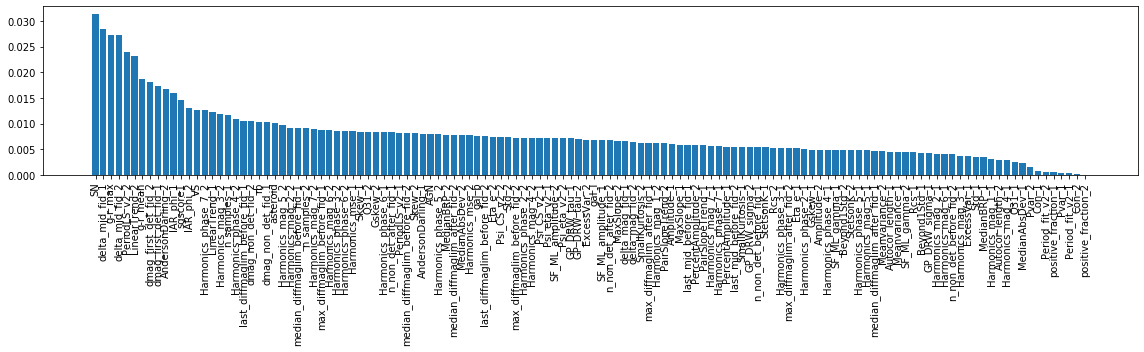

In [16]:
#plotting feature importance
plot_feature_importances(rf_model_transient, features_transient, feature_importance_name_transient_layer)

 ## Putting al layers together  


In [17]:
# generating final probabilities

#multiplying probabilities of the hierarchical layer with the other layers
prob_periodic = y_pred_proba_periodic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
prob_stochastic = y_pred_proba_stochastic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
prob_trainsient = y_pred_proba_transient*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final = np.concatenate((prob_stochastic,prob_trainsient,prob_periodic),axis=1)
#prob_final = np.concatenate((prob_stochastic,prob_periodic),axis=1)

print(np.sum(prob_final,axis=1),np.mean(np.sum(prob_final,axis=1)),np.std(np.sum(prob_final,axis=1)))

#getting the ordered name of classes for prob_final
prob_final_class_names = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
#prob_final_class_names = np.concatenate((classes_order_proba_stochastic,classes_order_proba_periodic))

print(prob_final_class_names)


class_final_proba = np.amax(prob_final,axis=1)
class_final_index = np.argmax(prob_final,axis=1)
class_final_name = [prob_final_class_names[x] for x in class_final_index]



[1. 1. 1. ... 1. 1. 1.] 1.0 9.40883401423798e-17
['AGN-I' 'Blazar' 'CV/Nova' 'LPV' 'RS-CVn' 'SLSN' 'SNII' 'SNIa' 'SNIbc'
 'Ceph' 'DSCT' 'EBC' 'EBSD/D' 'Periodic-Other' 'RRL']


[[1768  269    5    3    1    0   29    4    4    5    9    0   11    6
     5]
 [  35   97   15    0    1    0    2    0    2    2   10    0    4    1
     7]
 [   5   12   89   11    0    0    0    0    3    4   16    4    1    1
     4]
 [   0    0    0   86   32    7    6    0    0    0    0    0    0    1
     0]
 [   0    0    0    4    3    2    0    0    0    0    0    0    0    0
     0]
 [   1    1    0    5    7   12   11    0    0    0    0    0    1    0
     0]
 [   0    0    0    0    0    0    4    0    0    0    0    0    0    0
     0]
 [  41   24   45    0    0    0    0 2183  816  323   82  122  319   25
   769]
 [   7    7   16    0    0    0    0  272  548   94   45   36  103    5
   124]
 [   2    1    0    0    0    0    0    6    4   94    4    0    3    3
     7]
 [  62   50   12    1    0    1    1  104   94  409 4290  208   36   23
   517]
 [   0    0    0    0    0    0    0    1    1    3   14   71    4    7
     9]
 [   1    1    0    0    0    0    0   2

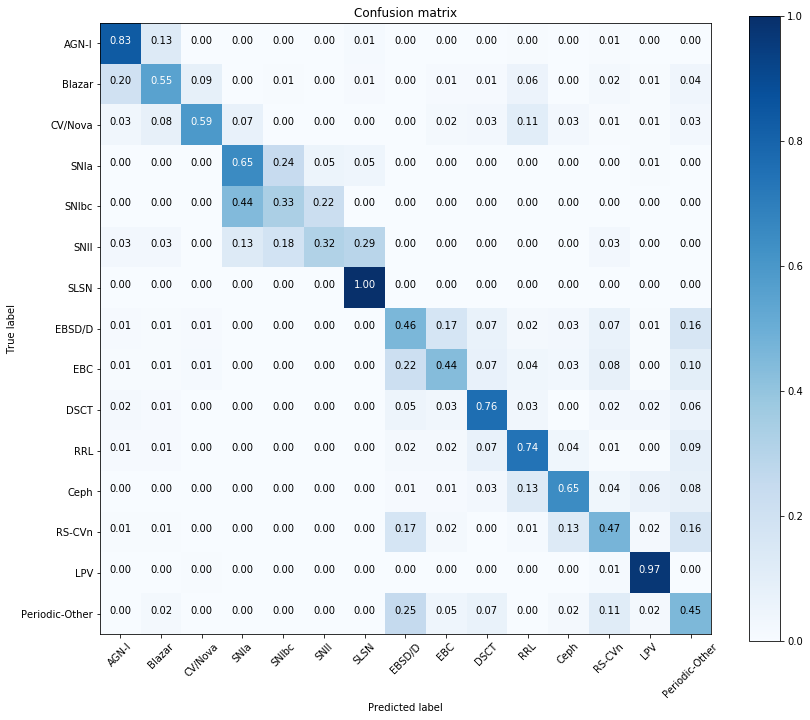

In [18]:
# generating confusion matrix for multilabels
cnf_matrix = metrics.confusion_matrix(y_test_original, class_final_name,labels=label_order)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,label_order, conf_matrix_name_second_layer)

print("Accuracy:", metrics.accuracy_score(y_test_original, class_final_name))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test_original, class_final_name))

In [19]:
# Kaggle score

num_y_test =  [np.where(prob_final_class_names==x)[0][0] for x in y_test_original] #label_encoder.transform(y_test)

#print(num_y_test)

CLASSES_REDUCED_V2 = prob_final_class_names

def kaggle_loss(labels, predictions, weights=None):
    np.clip(predictions, 10**-15, 1-10**-15, out=predictions)
    classes = np.unique(labels)
    if weights is None:
        weights = np.ones(len(classes), dtype=np.float64)/len(classes)
    loss_sum = 0
    labels = np.array(labels)
    for i in classes:
        p = predictions[labels == i, i]
        class_score = np.mean(np.log(p))*weights[i]
        print(CLASSES_REDUCED_V2[i], class_score)
        loss_sum += class_score
    return -loss_sum/sum(weights)



print(kaggle_loss(num_y_test,prob_final))

AGN-I -0.05318407096988828
Blazar -0.0918151281028469
CV/Nova -0.11728638942471412
LPV -0.026960335324186693
RS-CVn -0.11372444185971575
SLSN -0.06643823127629442
SNII -0.09863319705910487
SNIa -0.0772801580092114
SNIbc -0.08213298542233699
Ceph -0.08503884242996387
DSCT -0.06925061256107316
EBC -0.0999209643518348
EBSD/D -0.09701908015785242
Periodic-Other -0.10196696187292142
RRL -0.07092572948794469
1.2515771283098898


  ## Analysis post classification in training set

In [20]:
oids_test = y_test_original.index.values
classified_names = np.array(class_final_name)

LPV_asAGN = oids_test[np.where((y_test_original.values=='SNII') & (classified_names=='Blazar'))]

print(LPV_asAGN) 

['ZTF18abrzbtb']


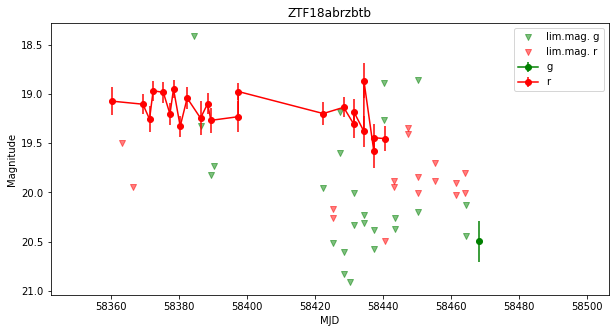

In [21]:

import psycopg2
import json

credentials_file = "alercereaduser.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]
    

conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])
    
    
def plotLC(oid, SN_det, SN_nondet):
    fig, ax = plt.subplots(figsize = (10, 5))
    labels = {1: 'g', 2: 'r'}
    colors = {1: 'g', 2: 'r'}
    for fid in [1, 2]:
        mask = SN_det.fid == fid
        if np.sum(mask) > 0:            
            ax.errorbar(SN_det[mask].mjd, SN_det[mask].magpsf_corr, 
                yerr = SN_det[mask].sigmapsf_corr, c = colors[fid], marker = 'o', label = labels[fid])
        mask = (SN_nondet.fid == fid) & (SN_nondet.diffmaglim > -900)
        if np.sum(mask) > 0:            
            ax.scatter(SN_nondet[mask].mjd, SN_nondet[mask].diffmaglim, c = colors[fid], alpha = 0.5,
                marker = 'v', label = "lim.mag. %s" % labels[fid])
    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("Magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])
    
    
def getSNdata(oid, doplot = False, doNED = False):

    # query detections and sort by mjd
    query="select oid, ra, dec, fid, mjd, magpsf_corr, sigmapsf_corr from detections where oid='%s'" % oid
    SN_det = pd.read_sql_query(query, conn)
    SN_det.sort_values(by=['mjd'], inplace=True)
        
    # query non detections and sort by mjd
    query="select oid, fid, mjd, diffmaglim from non_detections where oid='%s'" % oid
    SN_nondet = pd.read_sql_query(query, conn)
    SN_nondet.sort_values(by=['mjd'], inplace=True)
    
    if doplot:
        plotLC(oid, SN_det, SN_nondet)
        
    # find NED galaxies
    if doNED:
        co = coordinates.SkyCoord(ra=SNe.meanra[oid], dec=SNe.meandec[oid], unit=(u.deg, u.deg), frame='fk4')
        result_table = Ned.query_region(co, radius=0.01 * u.deg, equinox='J2000.0')
        display(result_table)
                
    # return data
    return SN_det, SN_nondet


for oid in LPV_asAGN:
    getSNdata(oid, doplot = True, doNED = False);

  ## Classifying unlabeled data

In [22]:
#loading the data

rm_nd_cols = ['n_det_fid_1', 'n_det_fid_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2',
             'Mean_1', 'Mean_2']

df_feat_ul = df_feat.join(df_early_probs, how='left').drop(rm_nd_cols, axis=1)
df_feat_ul.fillna(-999,inplace=True)

df_feat_ul_stochastic = df_feat_ul.drop(vs_cols, axis=1)
df_feat_ul = df_feat_ul.drop(early_cols, axis=1)


df_feat_ul.head()

,n_samples_1,Amplitude_1,AndersonDarling_1,Autocor_length_1,Beyond1Std_1,Con_1,Eta_e_1,Gskew_1,MaxSlope_1,Meanvariance_1,...,median_diffmaglim_before_fid_1,median_diffmaglim_before_fid_2,n_non_det_after_fid_1,n_non_det_after_fid_2,n_non_det_before_fid_1,n_non_det_before_fid_2,positive_fraction_1,positive_fraction_2,rb,sgscore1
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18abmdodl,16.0,0.218081,0.999875,1.0,0.437500,0.0,1.996542,-0.189670,0.090894,0.009344,...,19.997600,20.536699,32,28,6,5,0.250000,0.2,0.705714,1.00000
ZTF18abgqxmt,39.0,0.134584,0.850023,3.0,0.282051,0.0,0.024104,-0.069325,0.864548,0.004688,...,-999.000000,20.529499,15,61,0,1,1.000000,-999.0,-999.000000,-999.00000
ZTF19aamoyqu,9.0,0.045067,0.223764,1.0,0.333333,0.0,2.327832,-0.012154,0.017919,0.001721,...,19.417749,20.085250,11,19,2,6,0.000000,-999.0,-999.000000,-999.00000
ZTF18aazfdfq,61.0,0.193347,1.000000,1.0,0.344262,0.0,1.129305,0.262148,0.329393,0.009998,...,20.709050,-999.000000,62,85,2,0,0.645161,-999.0,-999.000000,-999.00000
ZTF18aagtntk,28.0,0.283235,1.000000,1.0,0.250000,0.0,1.463682,0.078873,0.095060,0.010448,...,19.788601,20.281300,43,75,11,13,0.800000,0.0,0.723095,0.99875


In [23]:
#predicting classes of unlabeled data

test_Y_hierarchical = rf_model_hierarchical.predict(df_feat_ul)
test_Y_proba_hierarchical = rf_model_hierarchical.predict_proba(df_feat_ul)

test_Y_periodic = rf_model_periodic.predict(df_feat_ul)
test_Y_proba_periodic = rf_model_periodic.predict_proba(df_feat_ul)

test_Y_stochastic = rf_model_stochastic.predict(df_feat_ul_stochastic)
test_Y_proba_stochastic = rf_model_stochastic.predict_proba(df_feat_ul_stochastic)

test_Y_transient = rf_model_transient.predict(df_feat_ul_stochastic)
test_Y_proba_transient = rf_model_transient.predict_proba(df_feat_ul_stochastic)


#multiplying probabilities
prob_periodic_ul = test_Y_proba_periodic*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
prob_stochastic_ul = test_Y_proba_stochastic*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
prob_trainsient_ul = test_Y_proba_transient*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final_ul = np.concatenate((prob_stochastic_ul,prob_trainsient_ul,prob_periodic_ul),axis=1)
#prob_final_ul = np.concatenate((prob_stochastic_ul,prob_periodic_ul),axis=1)


print(np.sum(prob_final_ul,axis=1),np.mean(np.sum(prob_final_ul,axis=1)),np.std(np.sum(prob_final_ul,axis=1)))

#getting the ordered name of classes for prob_final
prob_final_class_names_ul = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
#prob_final_class_names_ul = np.concatenate((classes_order_proba_stochastic,classes_order_proba_periodic))

print(prob_final_class_names)


class_final_proba_ul = np.amax(prob_final_ul,axis=1)
class_final_index_ul = np.argmax(prob_final_ul,axis=1)
class_final_name_ul = [prob_final_class_names_ul[x] for x in class_final_index_ul]


[1. 1. 1. ... 1. 1. 1.] 1.0 1.0130590815000818e-16
['AGN-I' 'Blazar' 'CV/Nova' 'LPV' 'RS-CVn' 'SLSN' 'SNII' 'SNIa' 'SNIbc'
 'Ceph' 'DSCT' 'EBC' 'EBSD/D' 'Periodic-Other' 'RRL']


In [24]:
#Writing results in the output

df_out = df_feat.join(df_early_probs)
print(df_out.shape)
print(len(class_final_name_ul))
print(len(prob_final_ul))


df_out['predicted_class'] = class_final_name_ul
df_out['predicted_class_proba'] = class_final_proba_ul


probs_header = prob_final_class_names_ul + '_prob'

prob_pd_ul = pd.DataFrame(prob_final_ul,columns=probs_header,index=df_out.index)

prob_h_pd_ul = pd.DataFrame(test_Y_proba_hierarchical, columns=['prob_Periodic','prob_Stochastic','prob_Transient'],index=df_out.index)
#prob_h_pd_ul = pd.DataFrame(test_Y_proba_hierarchical, columns=['prob_Periodic','prob_Stochastic'],index=df_out.index)

test_data_withclass = df_out.join(prob_pd_ul).join(prob_h_pd_ul)

test_data_withclass.to_csv(class_output)

test_data_withclass.head()


(602710, 137)
602710
602710


,n_samples_1,Amplitude_1,AndersonDarling_1,Autocor_length_1,Beyond1Std_1,Con_1,Eta_e_1,Gskew_1,MaxSlope_1,Mean_1,...,SNIbc_prob,Ceph_prob,DSCT_prob,EBC_prob,EBSD/D_prob,Periodic-Other_prob,RRL_prob,prob_Periodic,prob_Stochastic,prob_Transient
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18abmdodl,16.0,0.218081,0.999875,1.0,0.437500,0.0,1.996542,-0.189670,0.090894,15.531518,...,0.000952,0.059040,0.137760,0.340464,0.356208,0.061008,0.029520,0.984,0.012,0.004
ZTF18abgqxmt,39.0,0.134584,0.850023,3.0,0.282051,0.0,0.024104,-0.069325,0.864548,15.708959,...,0.000648,0.016200,0.013320,0.009360,0.007920,0.008520,0.004680,0.060,0.936,0.004
ZTF19aamoyqu,9.0,0.045067,0.223764,1.0,0.333333,0.0,2.327832,-0.012154,0.017919,16.162223,...,0.001092,0.018424,0.039200,0.022736,0.025088,0.073696,0.016856,0.196,0.798,0.006
ZTF18aazfdfq,61.0,0.193347,1.000000,1.0,0.344262,0.0,1.129305,0.262148,0.329393,14.641050,...,0.000344,0.140616,0.286440,0.282968,0.109368,0.031248,0.017360,0.868,0.130,0.002
ZTF18aagtntk,28.0,0.283235,1.000000,1.0,0.250000,0.0,1.463682,0.078873,0.095060,14.940813,...,0.000000,0.045024,0.410844,0.208236,0.136948,0.050652,0.086296,0.938,0.062,0.000


(array([ 93503.,  66415.,  56560.,  47197.,  42231.,  39487.,  37332.,
         42456.,  54445., 123084.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

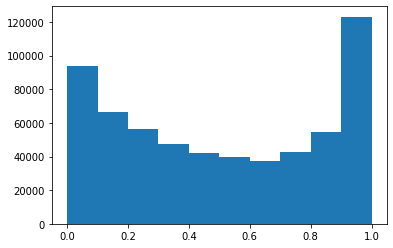

In [25]:
test_data_withclass.shape
plt.hist(prob_h_pd_ul['prob_Periodic'])

Text(0.5, 1.0, 'sources classified')

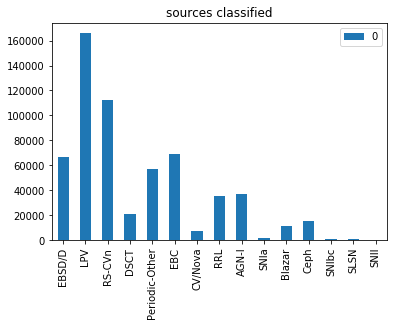

In [26]:
letter_counts = Counter(class_final_name_ul)
df_hist = pd.DataFrame.from_dict(letter_counts, orient='index')
df_hist.plot(kind='bar')
#plt.yscale('log')
plt.title('sources classified')

0 AGN-I 0.384518
1 Blazar 0.256098
2 CV/Nova 0.276532
3 LPV 0.59136
4 RS-CVn 0.32668800000000003
5 SLSN 0.266256
6 SNII 0.28116599999999997
7 SNIa 0.320484
8 SNIbc 0.304
9 Ceph 0.28446
10 DSCT 0.27692399999999995
11 EBC 0.29504
12 EBSD/D 0.29716800000000004
13 Periodic-Other 0.280188
14 RRL 0.44838199999999995


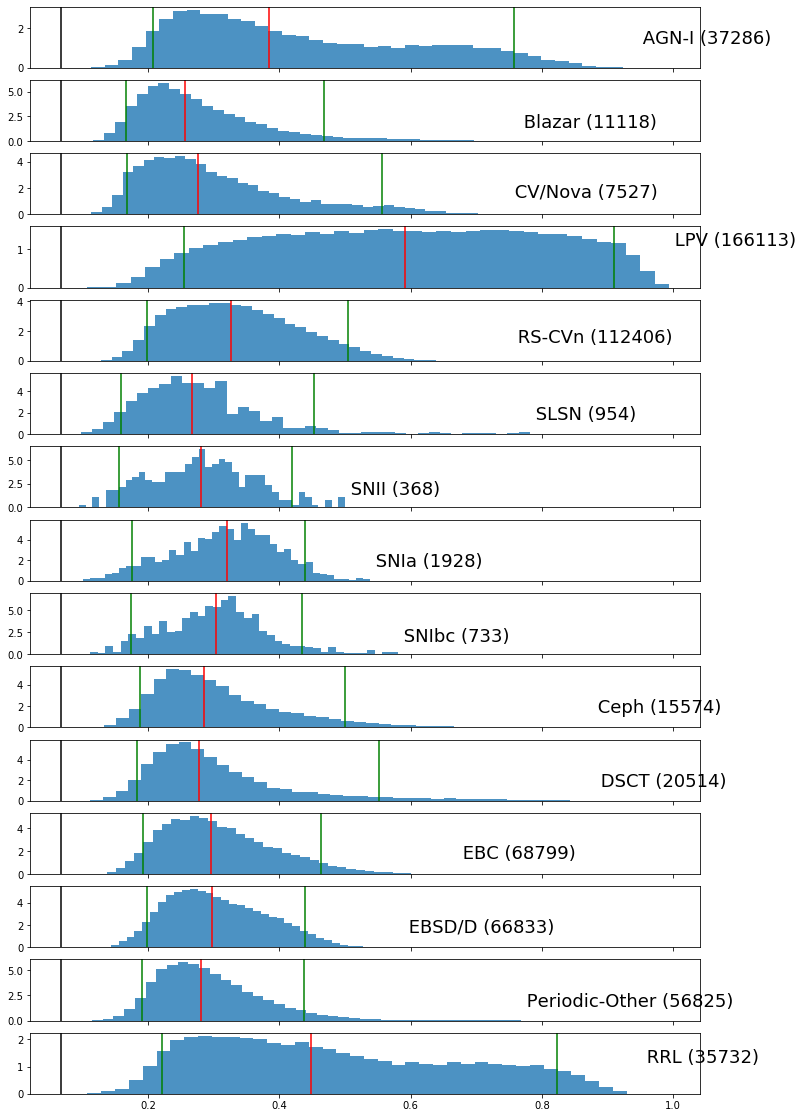

In [27]:

fig, ax = plt.subplots(nrows = len(prob_final_class_names_ul), figsize=(12, 20), sharex=True)
for idx, cl in enumerate(prob_final_class_names_ul):
   #print(idx, cl)
   print(idx, cl, np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.))
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 95.), c='g')
   ax[idx].axvline(1/len(prob_final_class_names_ul), c = 'k')
   ax[idx].hist(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, density=True, bins=40, lw=5, label=cl, alpha=0.8)
   ax[idx].text(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].max(), 1., " %s (%i)" % (cl, test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].shape[0]), fontsize=18, va='bottom', ha='left')

/Users/psanchez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0 AGN-I 0.1461304168450006
1 Blazar 0.5678360162343967
2 CV/Nova 0.45525243025700135
3 SNIa 0.0012414373170486215
4 SNIbc 0.47777748107910156
5 SNII 0.1436189321018535
6 SLSN 0.09920723713750057
7 EBSD/D 0.6359917437650005
8 EBC 0.7291969331912505
9 DSCT 0.12822919526525123
10 RRL 0.07095024592389976
11 Ceph 0.9407419982732508
12 RS-CVn 0.9722617240394493
13 LPV 2.2383160483078015
14 Periodic-Other 0.9604331087973019


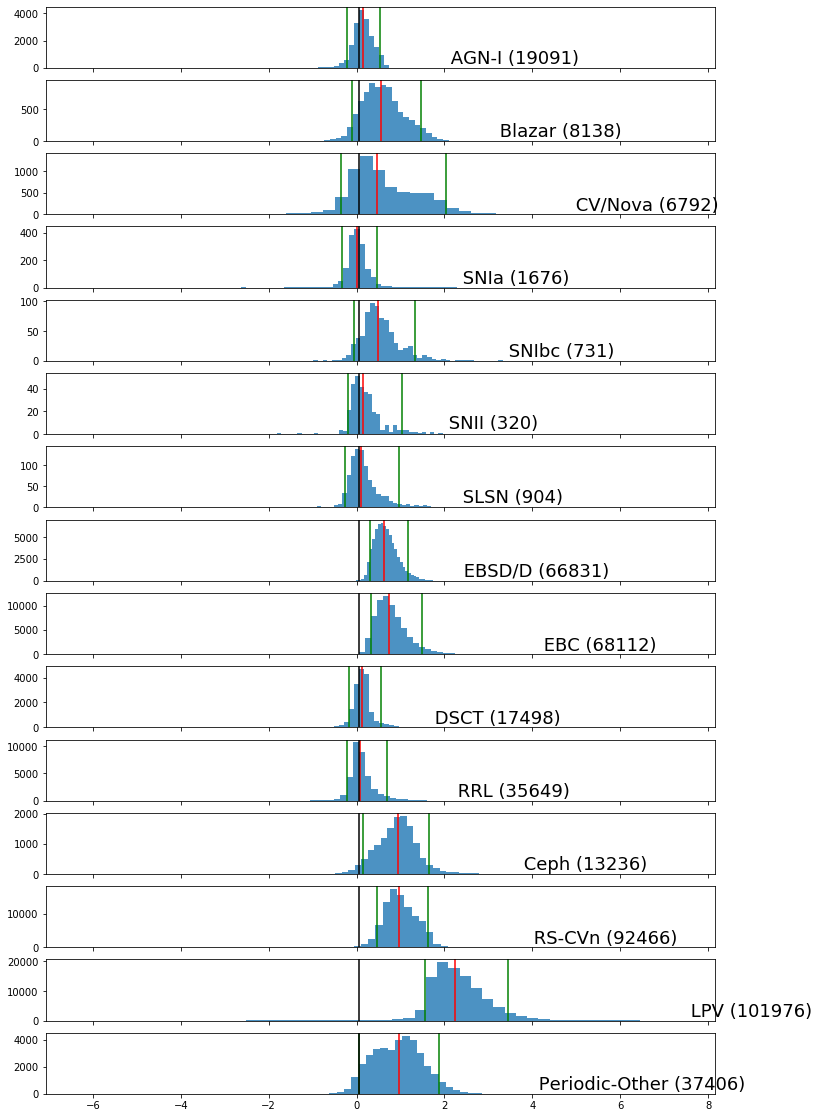

In [28]:
feature = 'g-r_max'
logscale = False
#df_train = df_train.join(labels)
df_plot = test_data_withclass#
df_plot = df_plot.loc[df_plot[feature]>-999] 
df_plot['class_original'] = df_plot['predicted_class']

fig, ax = plt.subplots(nrows = len(label_order), figsize=(12, 20), sharex=True)

for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(idx, cl, np.percentile(df_plot[feature][df_plot['class_original']==cl].values, 50.))
   ax[idx].axvline(np.percentile(df_plot[feature][df_plot['class_original']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(df_plot[feature][df_plot['class_original']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(df_plot[feature][df_plot['class_original']==cl].values, 95.), c='g')
   ax[idx].axvline(1/len(prob_final_class_names_ul), c = 'k')
   if logscale: ax[idx].hist(np.log10(df_plot[feature][df_plot['class_original']==cl].values), density=False, bins=40, lw=5, label=cl, alpha=0.8)
   else: ax[idx].hist(df_plot[feature][df_plot['class_original']==cl].values, density=False, bins=40, lw=5, label=cl, alpha=0.8)
   ax[idx].text(df_plot[feature][df_plot['class_original']==cl].max(), 1.5, " %s (%i)" % (cl, df_plot[feature][df_plot['class_original']==cl].shape[0]), fontsize=18, va='bottom', ha='left')

plt.savefig('../feature_analysis_train_set/'+feature+'.pdf')

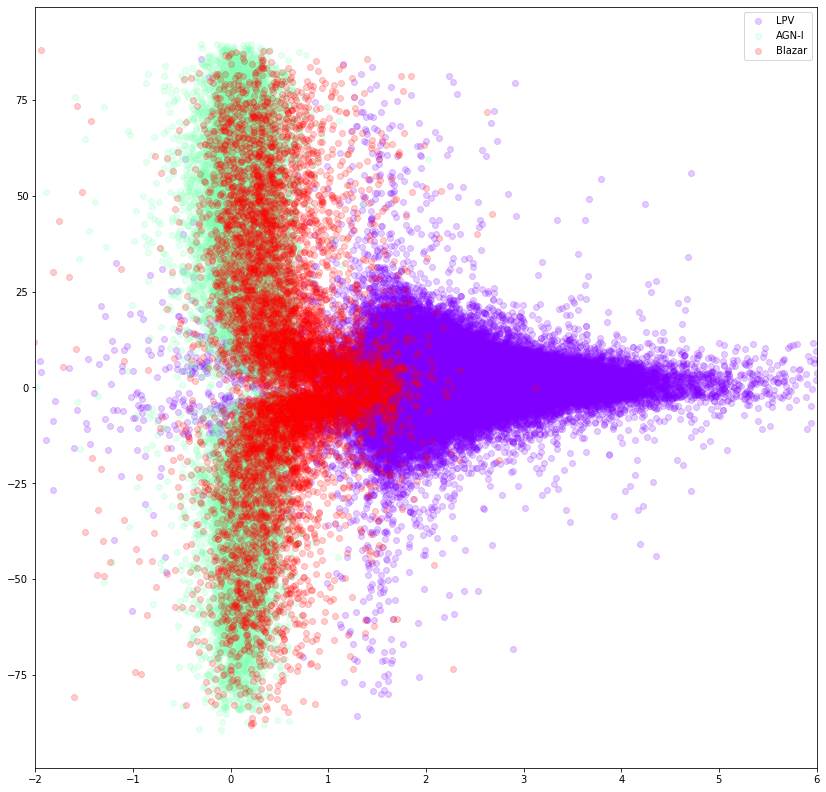

In [29]:
import matplotlib.cm as cm

feature_x = 'g-r_max'
feature_y = 'gal_b'
labels_list = ['LPV','AGN-I','Blazar']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
#df_train = df_train.join(labels)
df_plot = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xlim(-2,6)
for idx, cl in enumerate(labels_list):
   #print(idx, cl)
   ax.scatter(df_plot[feature_x][df_plot['predicted_class']==cl].values,df_plot[feature_y][df_plot['predicted_class']==cl].values,color=colors[idx],alpha=0.2,label=cl)
   
plt.legend()
#plt.savefig('../feature_analysis_train_set/'+feature+'.pdf')

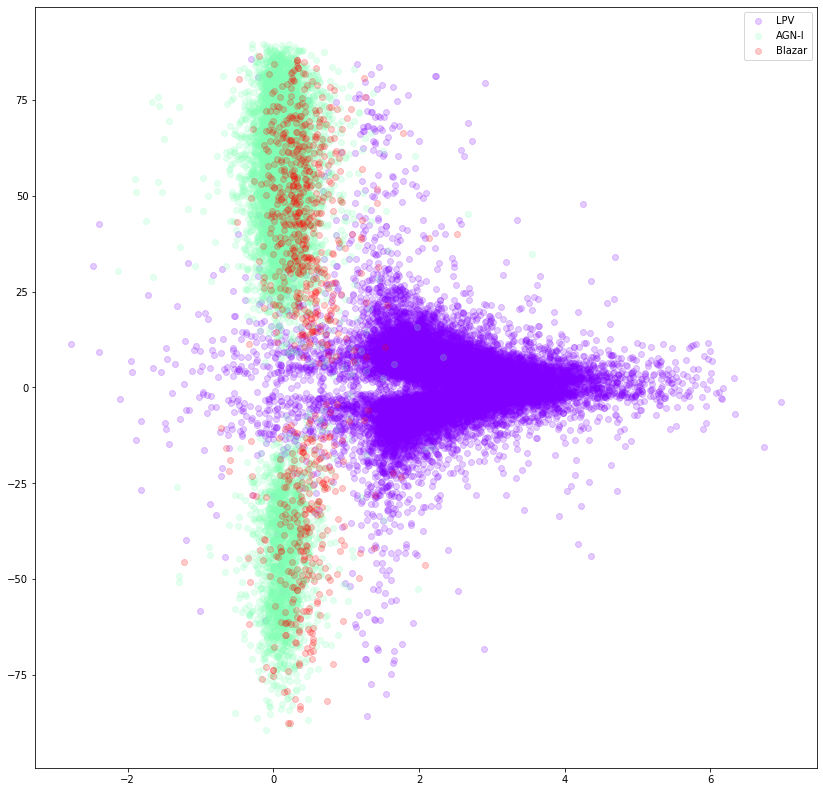

In [30]:
import matplotlib.cm as cm

feature_x = 'g-r_max'
feature_y = 'gal_b'
labels_list = ['LPV','AGN-I','Blazar']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))

df_plot = df.join(labels)
df_plot= df_plot.loc[(df_plot[feature_y]>-999) & (df_plot[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(14, 14))

for idx, cl in enumerate(labels_list):
   #print(idx, cl)
   ax.scatter(df_plot[feature_x][df_plot['class_original']==cl].values,df_plot[feature_y][df_plot['class_original']==cl].values,color=colors[idx],alpha=0.2,label=cl)
   
plt.legend()
#plt.savefig('../feature_analysis_train_set/'+feature+'.pdf')